# <center> AFG Oberseminar: Tomographic Reconstruction and Wavefront Set <center>
### <center> Héctor Andrade Loarca </center>
#### <center> 31st May 2018 </center>
<img src="./tub-afg.jpg" alt="Mountain View" style="width:250px;">

In [2]:
import odl
import scipy
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## Define geometry, operators and data

In [32]:
# Create ODL data structures
size = 128
space = odl.uniform_discr([-64, -64], [64, 64], [size, size],
                          dtype='float64')

### 121 angles, 4 scales

In [33]:
# Using as backend scikit-image
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=121)
operator = odl.tomo.RayTransform(space, geometry)

In [34]:
# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [35]:
# Assemble all operators into a list.
grad = odl.Gradient(space)
lin_ops = [operator, grad]
a = 0.001

In [36]:
phantom = odl.phantom.shepp_logan(space, True)

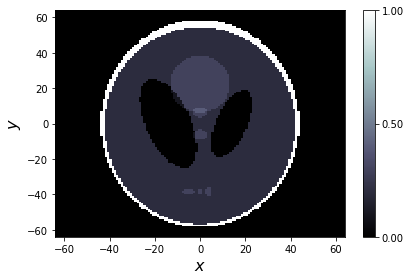

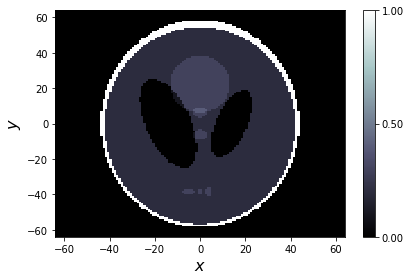

In [37]:
phantom.show()

In [38]:
data = operator(phantom)

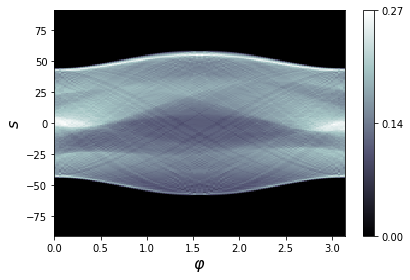

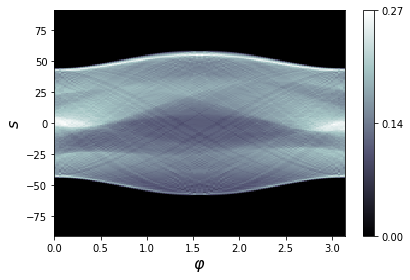

In [39]:
data.show()

## Tikhonov regularization

In [27]:
# Tikhonov with gradient
B = odl.Gradient(space)
a = 0.0001
T =  operator.adjoint * operator + a * B.adjoint * B
b = operator.adjoint(g)

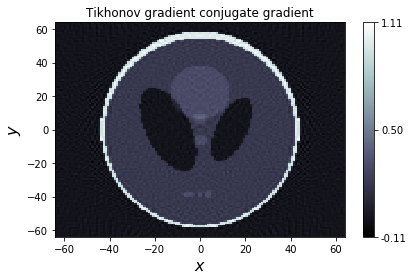

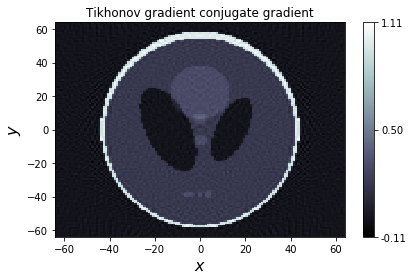

In [28]:
f = space.zero()
odl.solvers.conjugate_gradient(T, f, b, niter=100)
f.show('Tikhonov gradient conjugate gradient')

## TV Reconstruction

In [31]:
g = data

In [40]:
# Create functionals for the l2 distance and l1 norm.
g_funcs = [odl.solvers.L2NormSquared(operator.range).translated(g),
           a * odl.solvers.L1Norm(grad.range)]

In [41]:
# Functional of the bound constraint 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

In [42]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm = odl.power_method_opnorm(operator)
opnorm_grad = odl.power_method_opnorm(grad)

In [43]:
sigma = [1 / opnorm ** 2, 1 / opnorm_grad ** 2]
tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
x = space.zero()

In [44]:
odl.solvers.douglas_rachford_pd(x, f, g_funcs, lin_ops,
                                tau=tau, sigma=sigma, niter=100)

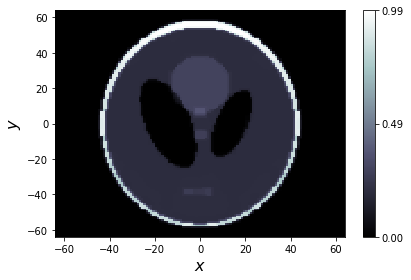

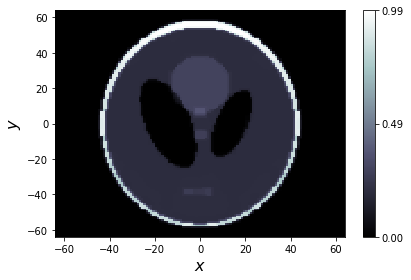

In [45]:
x.show()